### Connect to DuckDB and Configure S3/MinIO Access

The following cell initializes a DuckDB connection backed by a local database file and enables the `httpfs` extension to read and write data stored in MinIO via the S3 API. It sets the MinIO endpoint, disables SSL, applies path-style addressing, and loads S3 access credentials from environment variables.

In [2]:
import os
import duckdb

os.makedirs("/opt/de_project/warehouse", exist_ok=True)
db_path = "/opt/de_project/warehouse/taxi.duckdb"
con = duckdb.connect(db_path)

# Enable S3/MinIO access via DuckDB's httpfs extension
con.execute("INSTALL httpfs;")
con.execute("LOAD httpfs;")

# Configure DuckDB to connect to MinIO
con.execute("SET s3_endpoint = 'minio:9000';")
con.execute("SET s3_use_ssl = false;")
con.execute("SET s3_url_style = 'path';")

# Credentials
con.execute(f"SET s3_access_key_id = '{os.environ['AWS_ACCESS_KEY_ID']}';")
con.execute(f"SET s3_secret_access_key = '{os.environ['AWS_SECRET_ACCESS_KEY']}';")

con

In [3]:
row_count = con.execute("SELECT COUNT(*) FROM taxi.taxi.trips_prepared;").fetchone()[0]
row_count

2928254

### Sample 100 rows from the prepared Taxi Table

The next cell queries a subset of the prepared dataset from DuckDB, retrieves the results as a Pandas DataFrame, and displays the first few rows for inspection.

In [4]:
q = """
SELECT
    *
FROM taxi.taxi.trips_prepared
LIMIT 100;
"""
df = con.execute(q).fetchdf()
df.head()

,DOLocationID,PULocationID,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,payment_type,...,avg_mph,PU_Borough,PU_Zone,PU_service_zone,DO_Borough,DO_Zone,DO_service_zone,month,pickup_date,year
0,170,170,2,2002-12-31 22:59:39,2002-12-31 23:05:41,1,0.63,1,N,3,...,6.265193,Manhattan,Murray Hill,Yellow Zone,Manhattan,Murray Hill,Yellow Zone,01,2002-12-31,2024
1,264,137,2,2009-01-01 23:58:40,2009-01-02 00:01:40,1,0.46,1,N,2,...,9.200000,Manhattan,Kips Bay,Yellow Zone,Unknown,N/A,N/A,01,2009-01-01,2024
2,264,237,2,2009-01-01 23:30:39,2009-01-02 00:01:39,1,10.99,1,N,2,...,21.270968,Manhattan,Upper East Side South,Yellow Zone,Unknown,N/A,N/A,01,2009-01-01,2024
3,264,138,2,2009-01-01 00:24:09,2009-01-01 01:13:00,2,10.88,1,N,2,...,13.363357,Queens,LaGuardia Airport,Airports,Unknown,N/A,N/A,01,2009-01-01,2024
4,142,236,2,2023-12-31 23:56:46,2024-01-01 00:12:06,2,2.38,1,N,1,...,9.313043,Manhattan,Upper East Side North,Yellow Zone,Manhattan,Lincoln Square East,Yellow Zone,01,2023-12-31,2024


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   DOLocationID           100 non-null    int32         
 1   PULocationID           100 non-null    int32         
 2   VendorID               100 non-null    int32         
 3   tpep_pickup_datetime   100 non-null    datetime64[us]
 4   tpep_dropoff_datetime  100 non-null    datetime64[us]
 5   passenger_count        57 non-null     Int32         
 6   trip_distance          100 non-null    float64       
 7   RatecodeID             57 non-null     Int32         
 8   store_and_fwd_flag     57 non-null     object        
 9   payment_type           100 non-null    int32         
 10  fare_amount            100 non-null    float64       
 11  extra                  100 non-null    float64       
 12  mta_tax                100 non-null    float64       
 13  tip_am

### Descriptive statistics of the sampled dataset

The following cell computes summary statistics for all numeric columns in the DataFrame, allowing you to quickly inspect distributions, ranges, and potential data quality issues.


In [6]:
df.describe()

,DOLocationID,PULocationID,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,...,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,pickup_hour,dropoff_date,trip_duration_min,avg_mph,pickup_date,year
count,100.000000,100.000000,100.000000,100,100,57.0,100.000000,57.0,100.000000,100.000000,...,100.0,100.0000,57.000000,57.000000,100.000000,100,100.000000,100.000000,100,100.0
mean,159.410000,165.580000,1.530000,2023-05-05 00:02:13.920000,2023-05-05 00:19:05.920000,1.45614,2.497800,1.070175,0.770000,20.096300,...,1.0,26.8229,2.192982,0.092105,2.980000,2023-05-04 22:33:36,16.866667,8.928686,2023-05-04 20:24:00,2024.0
min,4.000000,4.000000,1.000000,2002-12-31 22:59:39,2002-12-31 23:05:41,0.0,0.000000,1.0,0.000000,3.000000,...,1.0,8.0000,0.000000,0.000000,0.000000,2002-12-31 00:00:00,0.316667,0.000000,2002-12-31 00:00:00,2024.0
25%,87.000000,122.250000,1.000000,2024-01-01 00:15:59.250000,2024-01-01 00:32:46.750000,1.0,0.400000,1.0,0.000000,10.000000,...,1.0,16.4100,2.500000,0.000000,0.000000,2024-01-01 00:00:00,7.012500,3.247443,2024-01-01 00:00:00,2024.0
50%,156.000000,158.000000,2.000000,2024-01-01 00:36:27.500000,2024-01-01 00:52:42.500000,1.0,1.470000,1.0,1.000000,15.950000,...,1.0,22.0200,2.500000,0.000000,0.000000,2024-01-01 00:00:00,13.250000,7.944843,2024-01-01 00:00:00,2024.0
75%,236.250000,236.000000,2.000000,2024-01-01 00:49:31.750000,2024-01-01 01:05:32.750000,2.0,2.970000,1.0,1.000000,28.330000,...,1.0,32.7675,2.500000,0.000000,0.000000,2024-01-01 00:00:00,22.337500,12.059567,2024-01-01 00:00:00,2024.0
max,265.000000,263.000000,2.000000,2024-01-01 00:58:16,2024-01-01 01:39:00,6.0,23.900000,5.0,4.000000,120.000000,...,1.0,127.9400,2.500000,1.750000,23.000000,2024-01-01 00:00:00,62.050000,41.285988,2024-01-01 00:00:00,2024.0
std,76.163447,66.805338,0.501614,NaN,NaN,0.867471,3.508533,0.529813,0.814701,15.515665,...,0.0,17.4750,0.827833,0.394243,7.748548,NaN,12.410828,8.067017,NaN,0.0


### Temporal Coverage Validation

Confirm whether the dataset covers the full expected day/hour range.  
This helps detect missing ingestion or partition issues.

In [7]:
con.execute("""
SELECT 
    MIN(pickup_date) AS min_date,
    MAX(pickup_date) AS max_date,
    COUNT(DISTINCT pickup_hour) AS distinct_hours
FROM taxi.taxi.trips_prepared;
""").fetchdf()

,min_date,max_date,distinct_hours
0,2002-12-31,2024-02-01,24


### Hourly aggregation

This query aggregates trips by pickup date and hour, computing trip counts and average metrics. The resulting DataFrame preview below helps confirm that the transformation and DuckDB ingestion produced coherent time-based features.

In [8]:
q = """
SELECT
    pickup_date,
    pickup_hour,
    COUNT(*) AS trips,
    AVG(trip_distance) AS avg_distance_miles,
    AVG(total_amount) AS avg_total_amount
FROM taxi.taxi.trips_prepared
GROUP BY 1, 2
ORDER BY 1, 2
LIMIT 100;
"""
df_hourly = con.execute(q).fetchdf()
df_hourly.head()

,pickup_date,pickup_hour,trips,avg_distance_miles,avg_total_amount
0,2002-12-31,22,1,0.63000,10.500000
1,2009-01-01,0,1,10.88000,68.290000
2,2009-01-01,23,2,5.72500,29.700000
3,2023-12-31,23,10,2.60100,22.462000
4,2024-01-01,0,6523,2.94086,27.438436


### Table schema and column profiling

This section inspects the full prepared table schema (as DuckDB sees it) and provides a quick column inventory.

In [9]:
# DuckDB's view of the prepared table schema
table_info = con.execute("PRAGMA table_info('taxi.taxi.trips_prepared');").fetchdf()
table_info

,cid,name,type,notnull,dflt_value,pk
0,0,DOLocationID,INTEGER,False,None,False
1,1,PULocationID,INTEGER,False,None,False
2,2,VendorID,INTEGER,False,None,False
3,3,tpep_pickup_datetime,TIMESTAMP,False,None,False
4,4,tpep_dropoff_datetime,TIMESTAMP,False,None,False
5,5,passenger_count,INTEGER,False,None,False
6,6,trip_distance,DOUBLE,False,None,False
7,7,RatecodeID,INTEGER,False,None,False
8,8,store_and_fwd_flag,VARCHAR,False,None,False
9,9,payment_type,INTEGER,False,None,False


### Duplicate check

Prepared data typically does not carry a single surrogate key per trip.  
This check approximates duplicates using a natural key derived from the pickup/dropoff timestamps plus locations.

In [11]:
# Define a pragmatic natural key (adjust if your model defines a different uniqueness constraint)
trip_key_cols = [c for c in [
    "tpep_pickup_datetime",
    "tpep_dropoff_datetime",
    "PULocationID",
    "DOLocationID",
    "trip_distance",
    "total_amount"
] if c in cols]

if len(trip_key_cols) < 4:
    raise ValueError(f"Not enough columns found for duplicate checking. Found: {trip_key_cols}")

key_expr = ", ".join([q_ident(c) for c in trip_key_cols])

dup_stats = con.execute(f"""\
SELECT
    COUNT(*) AS rows_total,
    COUNT(DISTINCT ROW({key_expr})) AS distinct_trip_keys
FROM taxi.taxi.trips_prepared;
""").fetchdf()

dup_stats["estimated_duplicates"] = dup_stats["rows_total"] - dup_stats["distinct_trip_keys"]
dup_stats

,rows_total,distinct_trip_keys,estimated_duplicates
0,2928254,2928254,0


### Constraint and outlier validation [Full Table]

These checks quantify how often key metrics fall outside reasonable operating ranges.  
They are intended as *signals* for data quality regressions, not strict business rules.

In [12]:
# Thresholds are intentionally conservative; adjust to your business context
checks = con.execute(f"""\
SELECT
    SUM(CASE WHEN trip_distance < 0 THEN 1 ELSE 0 END) AS trip_distance_negative,
    SUM(CASE WHEN trip_distance > 100 THEN 1 ELSE 0 END) AS trip_distance_gt_100,
    SUM(CASE WHEN total_amount < 0 THEN 1 ELSE 0 END) AS total_amount_negative,
    SUM(CASE WHEN total_amount > 500 THEN 1 ELSE 0 END) AS total_amount_gt_500,
    SUM(CASE WHEN trip_duration_min <= 0 THEN 1 ELSE 0 END) AS duration_le_0,
    SUM(CASE WHEN trip_duration_min > 300 THEN 1 ELSE 0 END) AS duration_gt_300,
    SUM(CASE WHEN avg_mph IS NOT NULL AND avg_mph > 90 THEN 1 ELSE 0 END) AS avg_mph_gt_90,
    SUM(CASE WHEN avg_mph IS NOT NULL AND avg_mph < 0 THEN 1 ELSE 0 END) AS avg_mph_negative
FROM taxi.taxi.trips_prepared;
""").fetchdf()

checks

,trip_distance_negative,trip_distance_gt_100,total_amount_negative,total_amount_gt_500,duration_le_0,duration_gt_300,avg_mph_gt_90,avg_mph_negative
0,0.0,56.0,0.0,56.0,0.0,1807.0,1049.0,0.0


### Zone enrichment coverage

Since pickup/dropoff attributes were joined from the zones reference table, confirm enrichment completeness.

In [13]:
zone_cov = con.execute("""\
SELECT
    SUM(CASE WHEN PU_Zone IS NULL THEN 1 ELSE 0 END) AS pu_zone_missing,
    SUM(CASE WHEN DO_Zone IS NULL THEN 1 ELSE 0 END) AS do_zone_missing,
    SUM(CASE WHEN PU_Borough IS NULL THEN 1 ELSE 0 END) AS pu_borough_missing,
    SUM(CASE WHEN DO_Borough IS NULL THEN 1 ELSE 0 END) AS do_borough_missing
FROM taxi.taxi.trips_prepared;
""").fetchdf()

for c in zone_cov.columns:
    zone_cov[c + "_pct"] = (zone_cov[c] / row_count) * 100.0

zone_cov

,pu_zone_missing,do_zone_missing,pu_borough_missing,do_borough_missing,pu_zone_missing_pct,do_zone_missing_pct,pu_borough_missing_pct,do_borough_missing_pct
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Categorical distributions [Full Table]

Profile the most important categorical dimensions to detect unexpected code values and skew.

In [14]:
# Payment type
if "payment_type" in cols:
    df_payment = con.execute("""\
    SELECT payment_type, COUNT(*) AS trips
    FROM taxi.taxi.trips_prepared
    GROUP BY 1
    ORDER BY trips DESC;
    """).fetchdf()
    df_payment
else:
    print("payment_type not present in this table.")

In [15]:
# RatecodeID
if "RatecodeID" in cols:
    df_ratecode = con.execute("""\
    SELECT RatecodeID, COUNT(*) AS trips
    FROM taxi.taxi.trips_prepared
    GROUP BY 1
    ORDER BY trips DESC;
    """).fetchdf()
    df_ratecode
else:
    print("RatecodeID not present in this table.")

In [16]:
# Passenger count
if "passenger_count" in cols:
    df_pax = con.execute("""\
    SELECT passenger_count, COUNT(*) AS trips
    FROM taxi.taxi.trips_prepared
    GROUP BY 1
    ORDER BY trips DESC;
    """).fetchdf()
    df_pax
else:
    print("passenger_count not present in this table.")

### Numeric distributions and percentiles [Sample & percentiles from Full Table)

We compute percentiles in SQL for stability over large volumes, and use a moderate sample for visualization.

In [17]:
# Percentiles over the full table (robust summary for large datasets)
percentiles = con.execute("""\
SELECT
    quantile_cont(trip_distance, [0.50, 0.90, 0.95, 0.99]) AS trip_distance_q,
    quantile_cont(total_amount,  [0.50, 0.90, 0.95, 0.99]) AS total_amount_q,
    quantile_cont(trip_duration_min, [0.50, 0.90, 0.95, 0.99]) AS trip_duration_min_q,
    quantile_cont(avg_mph, [0.50, 0.90, 0.95, 0.99]) AS avg_mph_q
FROM taxi.taxi.trips_prepared;
""").fetchdf()

percentiles

,trip_distance_q,total_amount_q,trip_duration_min_q,avg_mph_q
0,"[1.69, 8.41, 13.65, 20.0]","[20.16, 54.05, 80.5, 103.36]","[11.666666666666666, 28.9, 37.96666666666667, ...","[9.576059850374065, 19.970905680381712, 26.046..."


In [18]:
# Pull a larger sample for visualization (kept moderate to remain responsive)
sample_cols = [c for c in ["trip_distance", "total_amount", "trip_duration_min", "avg_mph"] if c in cols]
df_sample = con.execute(
    f"SELECT {', '.join(sample_cols)} FROM taxi.taxi.trips_prepared USING SAMPLE 5000;"
).fetchdf()

df_sample.describe()

,trip_distance,total_amount,trip_duration_min,avg_mph
count,5000.000000,5000.000000,5000.000000,5000.000000
mean,3.241906,27.505834,14.932283,11.236253
std,4.329530,21.575532,11.921731,6.926105
min,0.000000,0.000000,0.050000,0.000000
25%,0.990000,15.465000,7.283333,7.183266
50%,1.660000,20.130000,11.616667,9.509673
75%,3.120000,28.700000,18.716667,13.084347
max,43.940000,253.240000,130.616667,96.000000


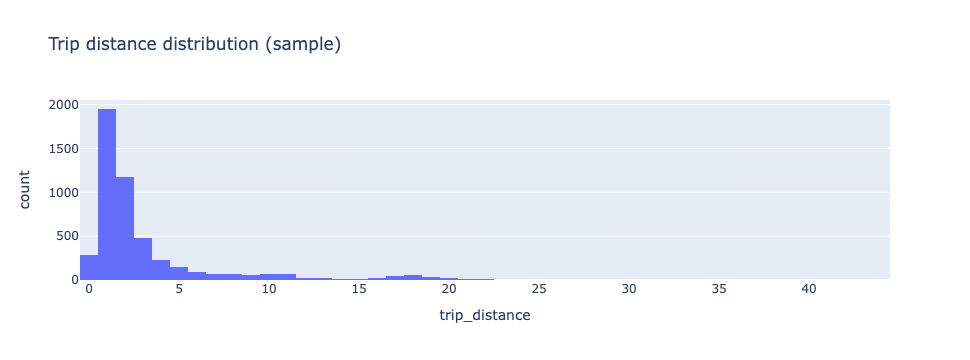

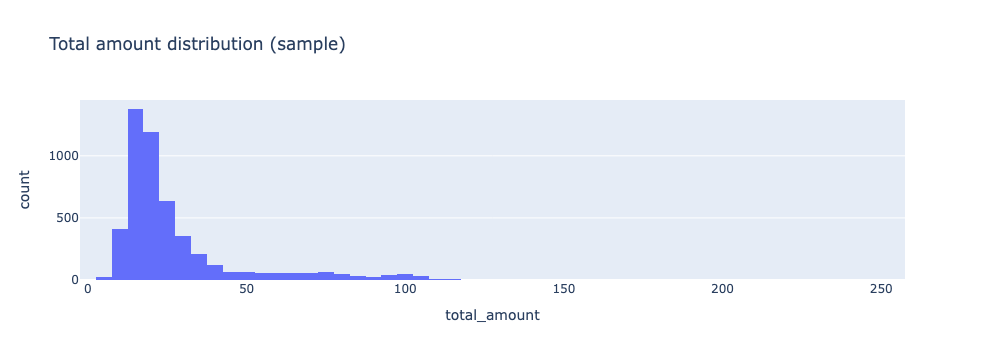

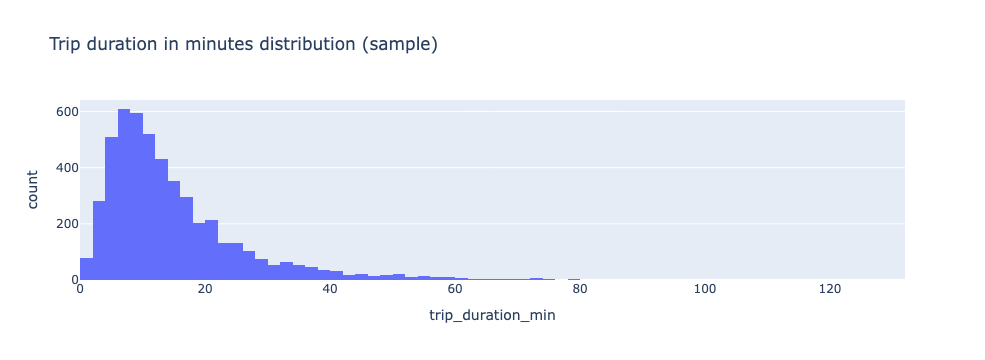

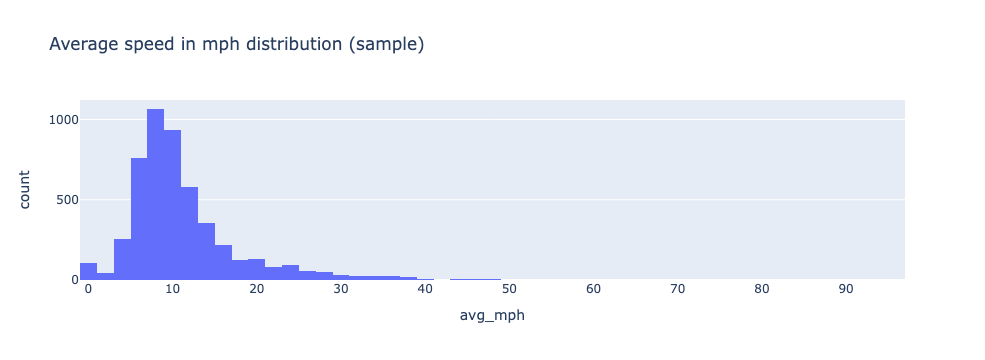

In [20]:
import plotly.express as px

# Trip distance distribution
if "trip_distance" in df_sample.columns:
    fig = px.histogram(df_sample, x="trip_distance", nbins=80, title="Trip distance distribution (sample)")
    fig.show()

# Total amount distribution
if "total_amount" in df_sample.columns:
    fig = px.histogram(df_sample, x="total_amount", nbins=80, title="Total amount distribution (sample)")
    fig.show()

# Trip duration distribution
if "trip_duration_min" in df_sample.columns:
    fig = px.histogram(df_sample, x="trip_duration_min", nbins=80, title="Trip duration in minutes distribution (sample)")
    fig.show()

# Average speed distribution
if "avg_mph" in df_sample.columns:
    fig = px.histogram(df_sample.dropna(subset=["avg_mph"]), x="avg_mph", nbins=80, title="Average speed in mph distribution (sample)")
    fig.show()

### Temporal patterns: trips by hour and weekday

This helps validate typical taxi demand cycles and identify gaps or anomalies.

In [21]:
# Trips by pickup hour
df_by_hour = con.execute("""\
SELECT
    pickup_hour,
    COUNT(*) AS trips,
    AVG(total_amount) AS avg_total_amount,
    AVG(trip_distance) AS avg_trip_distance
FROM taxi.taxi.trips_prepared
GROUP BY 1
ORDER BY 1;
""").fetchdf()

df_by_hour.head()

,pickup_hour,trips,avg_total_amount,avg_trip_distance
0,0,77747,28.690718,3.733956
1,1,52766,26.183709,3.131766
2,2,36818,24.935669,2.891919
3,3,24260,27.028012,3.328668
4,4,16322,32.450499,4.568031


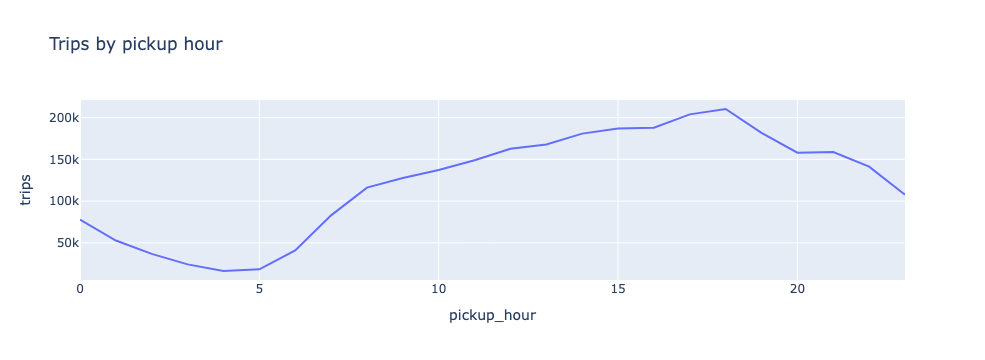

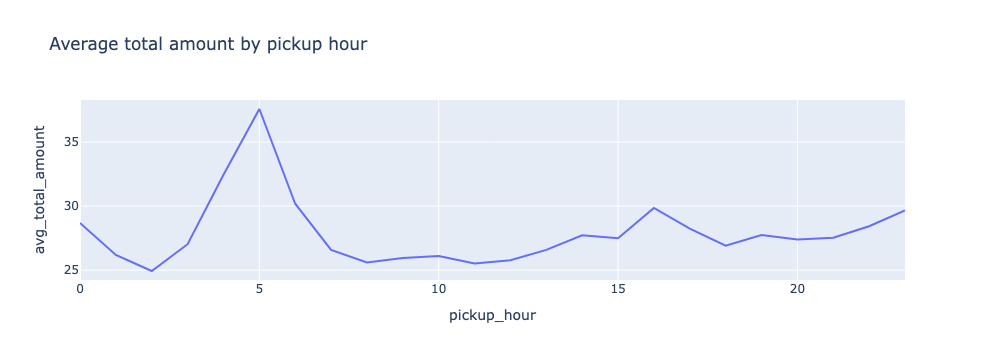

In [22]:
fig = px.line(df_by_hour, x="pickup_hour", y="trips", title="Trips by pickup hour")
fig.show()

fig = px.line(df_by_hour, x="pickup_hour", y="avg_total_amount", title="Average total amount by pickup hour")
fig.show()

In [23]:
# Trips by weekday (0=Sunday in DuckDB for EXTRACT('dow' ...))
df_by_dow = con.execute("""\
SELECT
    EXTRACT('dow' FROM pickup_date) AS dow,
    COUNT(*) AS trips,
    AVG(total_amount) AS avg_total_amount
FROM taxi.taxi.trips_prepared
GROUP BY 1
ORDER BY 1;
""").fetchdf()

df_by_dow

,dow,trips,avg_total_amount
0,0,334766,27.394409
1,1,402899,28.933502
2,2,458244,27.683695
3,3,489305,27.587766
4,4,423655,27.791310
5,5,403541,27.263648
6,6,415844,25.295759


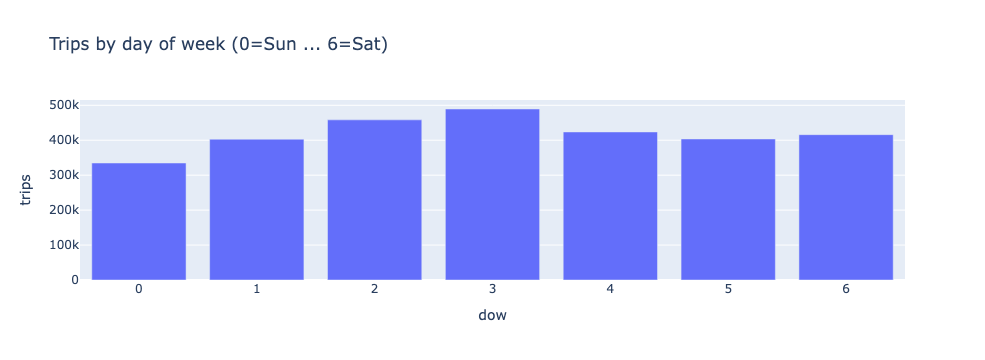

In [24]:
fig = px.bar(df_by_dow, x="dow", y="trips", title="Trips by day of week (0=Sun ... 6=Sat)")
fig.show()

### Spatial patterns: top zones and top OD pairs

Validate that zone enrichment is meaningful and identify high-volume corridors.

In [25]:
# Top pickup zones
df_top_pu = con.execute("""\
SELECT
    PU_Borough,
    PU_Zone,
    COUNT(*) AS trips
FROM taxi.taxi.trips_prepared
GROUP BY 1, 2
ORDER BY trips DESC
LIMIT 20;
""").fetchdf()

df_top_pu

,PU_Borough,PU_Zone,trips
0,Manhattan,Midtown Center,141807
1,Manhattan,Upper East Side South,141292
2,Queens,JFK Airport,141128
3,Manhattan,Upper East Side North,135376
4,Manhattan,Midtown East,105479
5,Manhattan,Times Sq/Theatre District,104653
6,Manhattan,Penn Station/Madison Sq West,103280
7,Manhattan,Lincoln Square East,103022
8,Queens,LaGuardia Airport,88560
9,Manhattan,Upper West Side South,87704


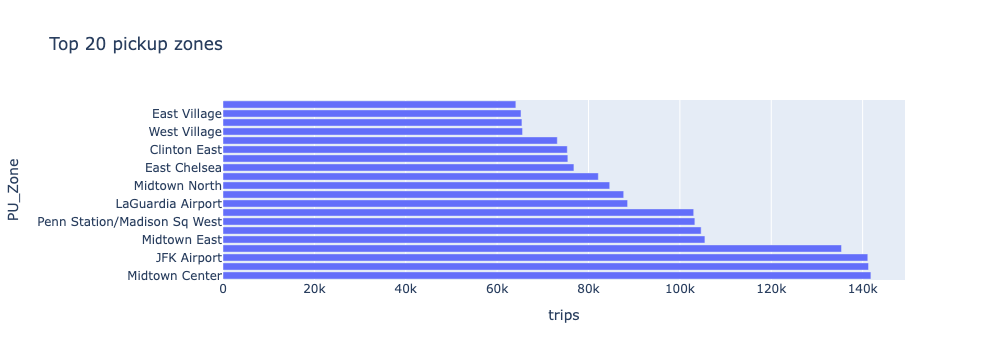

In [26]:
fig = px.bar(df_top_pu, x="trips", y="PU_Zone", orientation="h",
              title="Top 20 pickup zones", hover_data=["PU_Borough"])
fig.show()

In [27]:
# Top OD pairs (pickup->dropoff)
df_top_od = con.execute("""\
SELECT
    PU_Zone,
    DO_Zone,
    COUNT(*) AS trips,
    AVG(trip_distance) AS avg_trip_distance,
    AVG(total_amount) AS avg_total_amount
FROM taxi.taxi.trips_prepared
GROUP BY 1, 2
ORDER BY trips DESC
LIMIT 20;
""").fetchdf()

df_top_od

,PU_Zone,DO_Zone,trips,avg_trip_distance,avg_total_amount
0,Upper East Side South,Upper East Side North,21715,1.058145,15.738230
1,Upper East Side North,Upper East Side South,19277,1.045203,16.071472
2,Upper East Side North,Upper East Side North,15637,0.629996,13.640242
3,Upper East Side South,Upper East Side South,14567,0.628919,14.296077
4,Midtown Center,Upper East Side South,10170,1.074226,17.058608
5,Lincoln Square East,Upper West Side South,8886,0.985546,14.979524
6,Upper East Side South,Midtown Center,8755,1.057133,16.466569
7,Midtown Center,Upper East Side North,8706,1.944686,21.865861
8,Upper West Side South,Lincoln Square East,8598,0.879619,14.579534
9,Upper West Side South,Upper West Side North,8370,0.834573,13.828538
